# Section 1: TCAV
Please refer this source https://github.com/tensorflow/tcav on how you can import and run TCAV. The repository consists of an example (https://github.com/tensorflow/tcav/blob/master/Run_TCAV_on_colab.ipynb) of TCAV scores using GoogLeNet model trained on ImageNet dataset. The examples demonstrated the results based the concepts ["dotted","striped","zigzagged"] with target being 'zebra'. 

You are allowed to change the code template in accordance with the example provided. 

In [ ]:
# !pip install tcav
# !pip install tensorflow==1.15
# !pip install keras==2.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import InputLayer, Reshape, Flatten
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *

np.random.seed(1996)

In [54]:
import numpy as np
import tensorflow as tf
from keras import backend as k
from keras.models import Sequential
from keras.layers import InputLayer, Reshape, Flatten
from sklearn.linear_model import SGDClassifier

def extract_airplane_set():
    #TODO: Extract the indexes of all the images with 'airplane' as the output label from both train and test.
    #TODO: Return the preprocessed sets of both train and test sets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    interested_class_train = y_train == [0]
    interested_class_indx_train = [i for i, x in enumerate(interested_class_train) if x]
    x_train_airplane = x_train[interested_class_indx_train]
    print(len(x_train_airplane))
    y_train_airplane = y_train[interested_class_indx_train]
    print(len(y_train_airplane))
    interested_class_test = y_test == [0]
    interested_class_indx_test = [i for i, x in enumerate(interested_class_test) if x]
    x_test_airplane = x_test[interested_class_indx_test]
    y_test_airplane = y_test[interested_class_indx_test]

    return x_train_airplane, y_train_airplane, x_test_airplane, y_test_airplane

def extract_cloud_set():
    (x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()
    #TODO: Extract the indexes of all the images with 'cloud' as the output label for ONLY train set.
    #TODO: Return ONLY train set (No preprocess needed)
    concept = y_train_concept == [23]
    indices = concept
    indx_to_use = [i for i, x in enumerate(indices) if x]
    x_train_concept_cloud = x_train_concept[indx_to_use]
    y_train_concept_cloud = y_train_concept[indx_to_use]
 
    return x_train_concept_cloud, y_train_concept_cloud

def load_and_transfer_learn():
    # Load the ResNet50 model without the top layers
    tl_model = Sequential()

    resnet_model = ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=(32, 32, 3),
        pooling="avg"
      )

    # Freeze the pre-trained layers
    for layer in resnet_model.layers:
      layer.trainable = False
    
    tl_model.add(resnet_model)
    tl_model.add(Flatten())
    tl_model.add(Dense(512))
    tl_model.add(Activation('relu'))
    tl_model.add(Dropout(0.5))
    tl_model.add(Dense(1))
    tl_model.add(Activation('sigmoid'))
    return tl_model

def tcav_scores(model, x_train, y_train, x_train_concept):
    bottleneck = 3
    tf.compat.v1.disable_eager_execution()
    tcav_obj = TCAV()
    tcav_obj.set_model(model)
    tcav_obj.split_model(bottleneck = bottleneck, conv_layer = True)
    tcav_obj.train_cav(x_train_concept)
    tcav_obj.calculate_sensitivity(x_train, y_train)
    tcav_obj.print_sensitivity()



In [51]:
x_train, y_train, x_test, y_test = extract_airplane_set()

5000
5000


In [52]:
x_train_concept, y_train_concept = extract_cloud_set()

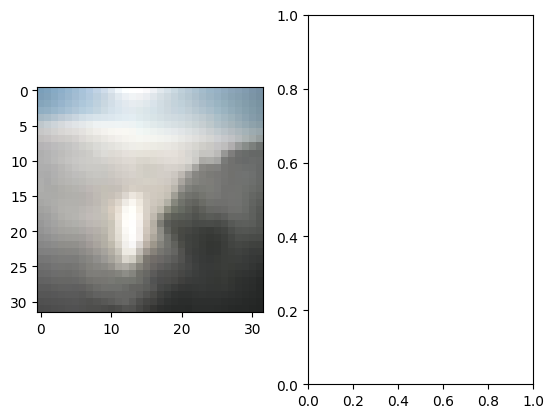

In [34]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_concept[0])
# axarr[1].imshow(x_train[7777])

In [55]:
model = load_and_transfer_learn()

##TODO: Define your choice of batch_size, number of epochs, loss function (e.g. categorical crossentropy), and optimizer (SGD\Adam)
batch_size = 32
epochs = 5
loss_func = "binary_crossentropy"    #<--- has to be in string format
optim = "SGD"       #<--- has to be in string format

checkpoint_path = "/content/drive/MyDrive/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.compile(loss=loss_func, optimizer=optim, metrics=['accuracy'])

In [56]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,  validation_data=(x_test, y_test),callbacks=[cp_callback], shuffle=True)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
4992/5000 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: saving model to /content/drive/MyDrive/training_2/cp.ckpt
5000/5000 [==============================] - 6s 1ms/sample - loss: 0.0048 - accuracy: 0.9990 - val_loss: 5.8765e-05 - val_accuracy: 1.0000
Epoch 2/5
5000/5000 [==============================] - ETA: 0s - loss: 3.1382e-04 - accuracy: 1.0000
Epoch 2: saving model to /content/drive/MyDrive/training_2/cp.ckpt
5000/5000 [==============================] - 4s 712us/sample - loss: 3.1382e-04 - accuracy: 1.0000 - val_loss: 3.7440e-05 - val_accuracy: 1.0000
Epoch 3/5
4896/5000 [============================>.] - ETA: 0s - loss: 2.0234e-04 - accuracy: 1.0000
Epoch 3: saving model to /content/drive/MyDrive/training_2/cp.ckpt
5000/5000 [==============================] - 3s 528us/sample - loss: 1.9872e-04 - accuracy: 1.0000 - val_loss: 2.7688e-05 - val_accuracy: 1.0000
Epoch 4/5
4960/5000 [============================>.] - ETA: 0s - loss: 8.5493e-05 - accuracy: 1.0000
Epoch 4: saving model to /content/drive/MyDrive/training_2/cp.ckpt

In [57]:
model.load_weights(checkpoint_path)

In [58]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [1.915079246100504e-05, 1.0]


In [59]:
tcav_scores(model, x_train, y_train, x_train_concept)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The sensitivity of class 1 is  nan
The sensitivity of class 0 is  1.0


/content/cav/tcav.py:154: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(self.sensitivity[np.where(self.y_labels == 1)[0]] > 0)
